In [1]:
from src import PINNViga
from src import Loss
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

EI = 1.0  # Rigidez flexional (N.m²) - escolha valor real conforme viga
q = 1.0   # Carga distribuída (N/m) - escolha valor real conforme viga
L = 1.0   # Comprimento da viga (m)

model, optimizer = PINNViga.create_model()
x, u = PINNViga.run_model(model, optimizer, L, EI, q)

Epoch 0, Loss: 24.268654, PDE Loss: 1.062495, BC Loss: 0.023206
Epoch 500, Loss: 0.012358, PDE Loss: 0.012335, BC Loss: 0.000000
Epoch 1000, Loss: 0.005263, PDE Loss: 0.005054, BC Loss: 0.000000
Epoch 1500, Loss: 0.008183, PDE Loss: 0.001887, BC Loss: 0.000006
Epoch 2000, Loss: 0.000735, PDE Loss: 0.000727, BC Loss: 0.000000
Epoch 2500, Loss: 0.000805, PDE Loss: 0.000791, BC Loss: 0.000000
Epoch 3000, Loss: 0.003320, PDE Loss: 0.001719, BC Loss: 0.000002
Epoch 3500, Loss: 0.004753, PDE Loss: 0.001717, BC Loss: 0.000003
Epoch 4000, Loss: 0.002900, PDE Loss: 0.001652, BC Loss: 0.000001
Epoch 4500, Loss: 0.002565, PDE Loss: 0.001312, BC Loss: 0.000001


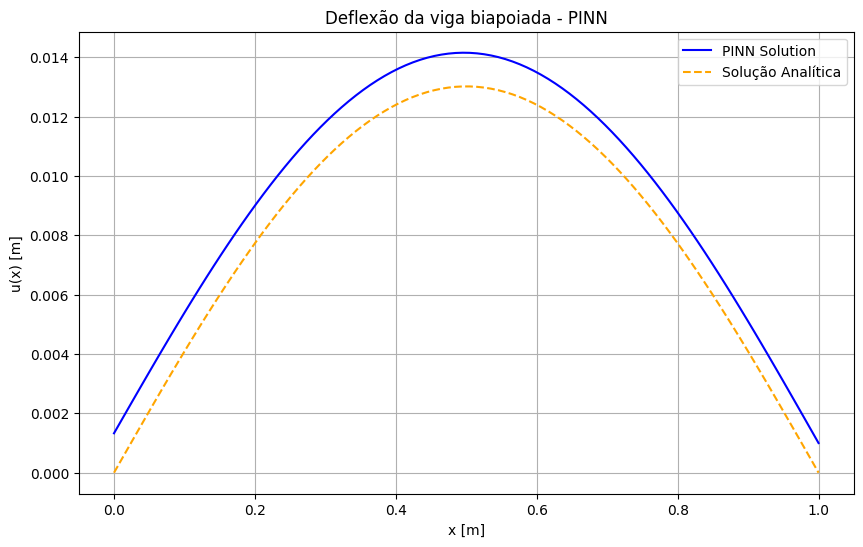

In [2]:
def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

plt.figure(figsize=(10, 6))
plt.plot(x, u, label='PINN Solution', color='blue')
plt.plot(x, y_calc(x), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga biapoiada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()